In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib.colors import ListedColormap

# -------------------------------
# Step 1: Load Dataset
# -------------------------------
# Using the Iris dataset which is well-suited for GMM
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [32]:
features = [
    {"feature_name": "sepal_length", "mean": -0.5, "std": 25},
    {"feature_name": "sepal_width", "mean": -0.5, "std": 35},
    {"feature_name": "petal_length", "mean": -0.5, "std": 25},
    {"feature_name": "petal_width", "mean": -0.5, "std": 45}
]
feature_stats = {f["feature_name"]: (f["mean"], f["std"]) for f in features}

In [33]:
# -------------------------------
# Step 2: Define Bayesian GMM Layer
# -------------------------------
class BayesianGMMLayer(nn.Module):
    def __init__(self, n_components, n_features, prior_mu, prior_sigma):
        super().__init__()
        self.n_components = n_components
        self.n_features = n_features

        # Variational parameters for means
        self.mean_mu = nn.Parameter(torch.randn(n_components, n_features) * 0.1)
        self.mean_log_sigma = nn.Parameter(torch.ones(n_components, n_features) * -5.0)

        # Variational parameters for covariances (using log-Cholesky parameterization)
        # For simplicity, we'll use diagonal covariances
        self.cov_log_diag = nn.Parameter(torch.zeros(n_components, n_features))

        # Variational parameters for mixture weights
        self.weight_logits = nn.Parameter(torch.zeros(n_components))

        # Priors
        self.prior_mean_mu = prior_mu.view(1, n_features)
        self.prior_mean_sigma = prior_sigma.view(1, n_features)

    def forward(self, x):
        # Sample from variational posterior
        mean_sigma = torch.exp(self.mean_log_sigma)
        means = self.mean_mu + mean_sigma * torch.randn_like(self.mean_mu)

        # Get precision matrices from log-diagonal
        precisions = torch.exp(-self.cov_log_diag)

        # Normalize mixture weights
        weights = torch.softmax(self.weight_logits, dim=0)

        # Compute log probabilities for each component
        n_samples = x.size(0)
        log_probs = torch.zeros(n_samples, self.n_components, device=x.device)

        for k in range(self.n_components):
            # Compute Mahalanobis distance
            diff = x - means[k]
            mahalanobis = torch.sum((diff**2) * precisions[k], dim=1)

            # Log determinant of precision matrix
            log_det_precision = torch.sum(self.cov_log_diag[k])

            # Log probability of Gaussian component
            log_probs[:, k] = torch.log(weights[k] + 1e-10) - 0.5 * (
                self.n_features * np.log(2 * np.pi) - log_det_precision + mahalanobis
            )

        # Log-sum-exp trick for numerical stability
        max_log_probs = torch.max(log_probs, dim=1, keepdim=True)[0]
        log_probs_stable = log_probs - max_log_probs
        probs = torch.exp(log_probs_stable)
        weighted_probs = torch.sum(probs, dim=1, keepdim=True)
        log_likelihood = max_log_probs + torch.log(weighted_probs)

        return log_likelihood, means, precisions, weights

    def kl_loss(self):
        # KL divergence for means
        mean_sigma = torch.exp(self.mean_log_sigma)
        kl_mean = torch.sum(
            torch.log(self.prior_mean_sigma / mean_sigma) +
            (mean_sigma**2 + (self.mean_mu - self.prior_mean_mu)**2) /
            (2 * self.prior_mean_sigma**2) - 0.5
        )

        # KL divergence for mixture weights (approximation using Dirichlet prior)
        # Using uniform Dirichlet prior (alpha=1)
        weights = torch.softmax(self.weight_logits, dim=0)
        kl_weights = torch.sum(weights * torch.log(weights * self.n_components + 1e-10))

        # KL divergence for covariances (approximation)
        # Using inverse-Wishart prior
        kl_cov = torch.sum(self.cov_log_diag)

        return kl_mean + kl_weights + kl_cov

In [34]:
# -------------------------------
# Step 3: Define the Bayesian GMM Model
# -------------------------------
class BayesianGMM(nn.Module):
    def __init__(self, n_components, n_features, prior_mu, prior_sigma):
        super().__init__()
        self.gmm = BayesianGMMLayer(n_components, n_features, prior_mu, prior_sigma)

    def forward(self, x):
        return self.gmm(x)

    def kl_loss(self):
        return self.gmm.kl_loss()

In [35]:
# -------------------------------
# Step 4: Define Priors
# -------------------------------
def define_random_priors(n_features):
    prior_mu = torch.randn(1, n_features)
    prior_sigma = torch.abs(torch.randn(1, n_features))*10
    return prior_mu, prior_sigma

def define_feature_specific_priors(feature_names, default=(0.0, 1.0)):
    input_dim = len(feature_names)
    prior_mu = torch.zeros(1, input_dim)
    prior_sigma = torch.ones(1, input_dim)

    for idx, name in enumerate(feature_names):
        mu, sigma = feature_stats.get(name, default)
        prior_mu[0, idx]    = mu
        prior_sigma[0, idx] = sigma
    return prior_mu, prior_sigma

In [36]:
# -------------------------------
# Step 5: Train Function
# -------------------------------
def train_model(model, X_train, X_test, epochs=300, samples=5):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    device = next(model.parameters()).device

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass with multiple samples
        log_likelihoods = torch.zeros((samples, X_train.size(0), 1), device=device)
        kl = 0.0

        for i in range(samples):
            log_likelihood, _, _, _ = model(X_train)
            log_likelihoods[i] = log_likelihood
            kl += model.kl_loss()

        kl /= samples

        # Negative ELBO loss
        log_likelihood_mean = log_likelihoods.mean(0)
        loss = -torch.mean(log_likelihood_mean) + (1.0 / X_train.size(0)) * kl

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            test_log_likelihoods = torch.zeros((samples, X_test.size(0), 1), device=device)

            for i in range(samples):
                test_log_likelihood, _, _, _ = model(X_test)
                test_log_likelihoods[i] = test_log_likelihood

            test_log_likelihood_mean = test_log_likelihoods.mean(0)
            test_loss = -torch.mean(test_log_likelihood_mean)
            test_losses.append(test_loss.item())

        # if (epoch + 1) % 50 == 0:
        #     print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    return train_losses, test_losses


In [37]:
n_components = 3 
n_features = X_train.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of random prior models to generate
num_random_models = 20  # You can adjust this number

# Lists to store the losses for each random model
train_losses_a_ls = []
test_losses_a_ls = []

print("Training model with random priors...")
# Generate multiple random prior models and evaluate each
for i in range(num_random_models):
    rand_prior_mu, rand_prior_sigma = define_random_priors(n_features)
    model_a = BayesianGMM(n_components, n_features, rand_prior_mu, rand_prior_sigma).to(device)
    
    # Move data to device
    X_train_device = X_train.to(device)
    X_test_device = X_test.to(device)
    
    # Train the model and get the losses
    train_loss, test_loss = train_model(model_a, X_train_device, X_test_device)
    
    # Store the losses
    train_losses_a_ls.append(train_loss)
    test_losses_a_ls.append(test_loss)


# Calculate average losses
train_loss_a = torch.tensor(train_losses_a_ls).mean(dim=0)
test_loss_a = torch.tensor(test_losses_a_ls).mean(dim=0)

# -------------------------------
# Step 6: Train Both Models
# -------------------------------
# Feature-specific priors
spec_prior_mu, spec_prior_sigma = define_feature_specific_priors(feature_names)
model_b = BayesianGMM(n_components, n_features, spec_prior_mu, spec_prior_sigma).to(device)

# Move data to device
X_train_device = X_train.to(device)
X_test_device = X_test.to(device)

print("\nTraining model with feature-specific priors...")
train_loss_b, test_loss_b = train_model(model_b, X_train_device, X_test_device)

Training model with random priors...

Training model with feature-specific priors...


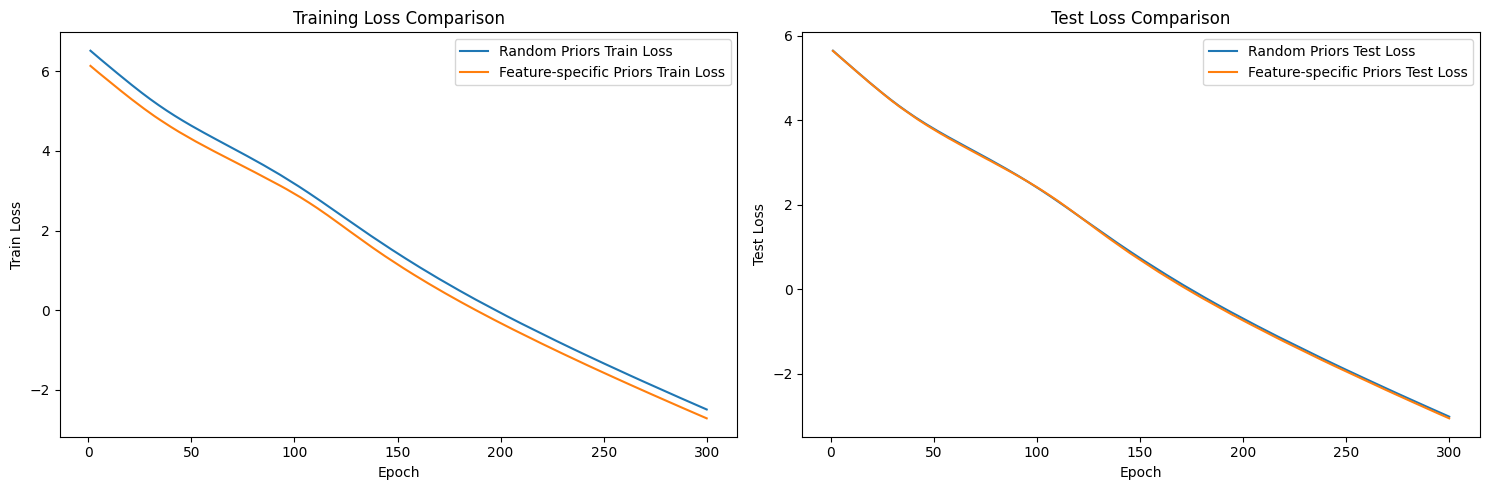


Final Train Loss (Random Priors): -2.4901
Final Test Loss (Random Priors): -3.0202
Final Train Loss (Feature-specific Priors): -2.7126
Final Test Loss (Feature-specific Priors): -3.0599


In [38]:
# -------------------------------
# Step 7: Plot Results
# -------------------------------
epochs = range(1, len(train_loss_a)+1)

plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_a, label='Random Priors Train Loss')
plt.plot(epochs, train_loss_b, label='Feature-specific Priors Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss Comparison')
plt.legend()

# Test Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, test_loss_a, label='Random Priors Test Loss')
plt.plot(epochs, test_loss_b, label='Feature-specific Priors Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# Final results
print(f"\nFinal Train Loss (Random Priors): {train_loss_a[-1]:.4f}")
print(f"Final Test Loss (Random Priors): {test_loss_a[-1]:.4f}")
print(f"Final Train Loss (Feature-specific Priors): {train_loss_b[-1]:.4f}")
print(f"Final Test Loss (Feature-specific Priors): {test_loss_b[-1]:.4f}")


Visualizing GMM components...


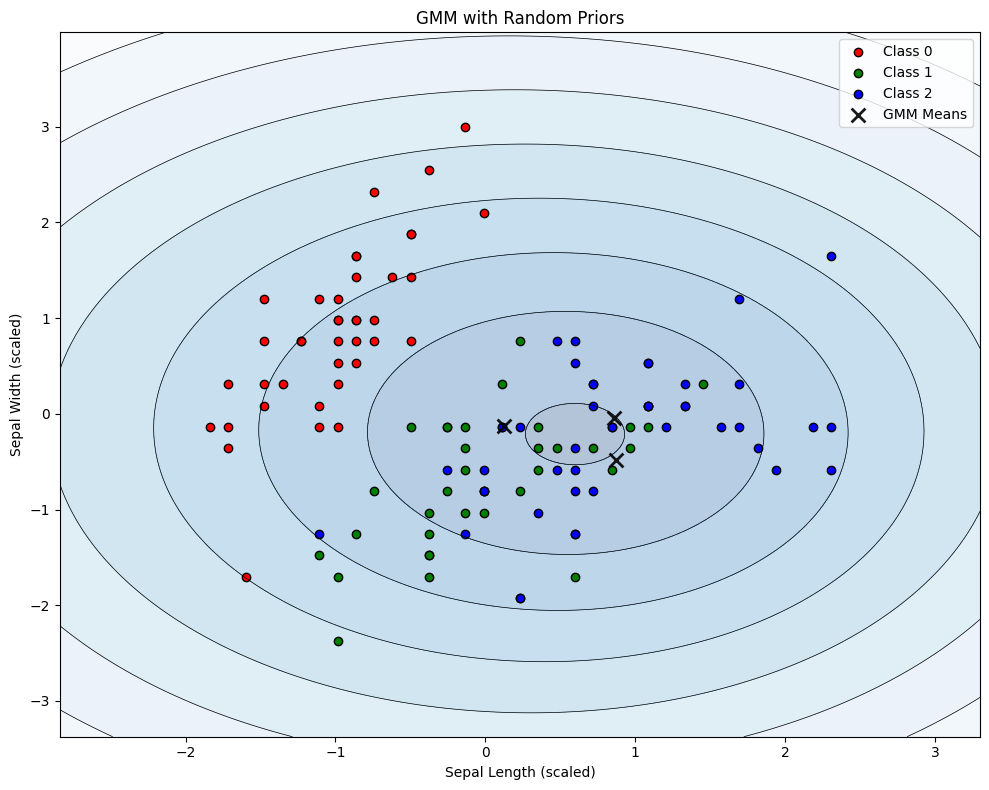

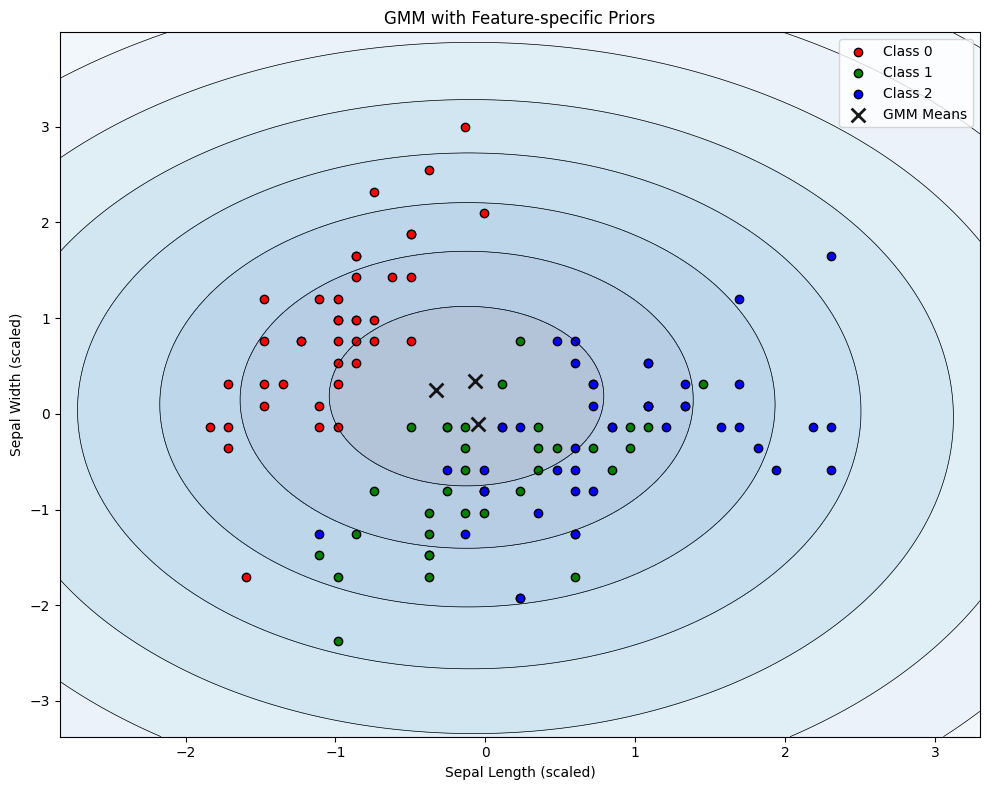

In [42]:
# -------------------------------
# Step 8: Visualize GMM Components
# -------------------------------
def plot_gmm(model, X, y, title):
    model.eval()
    with torch.no_grad():
        # Get GMM parameters
        _, means, precisions, weights = model(X)

    means_2d = means[:, :2].cpu().numpy()
    precisions_2d = precisions[:, :2].cpu().numpy()
    weights = weights.cpu().detach().numpy()

    # Create mesh grid for contour plot
    h = 0.02  # Step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Compute the GMM density for each point in the mesh grid
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    mesh_tensor = torch.tensor(mesh_data, dtype=torch.float32).to(device)

    Z = np.zeros(mesh_data.shape[0])
    for k in range(n_components):
        # Compute Gaussian probability for each point
        diff = mesh_data - means_2d[k]
        mahalanobis = np.sum((diff**2) * precisions_2d[k], axis=1)
        det_precision = np.prod(precisions_2d[k])

        norm_const = np.sqrt((2 * np.pi) ** n_features * (1.0 / det_precision))
        probs = np.exp(-0.5 * mahalanobis) / norm_const
        Z += weights[k] * probs

    Z = Z.reshape(xx.shape)

    # Plot data points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues, alpha=0.3)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

    # Plot the original data points
    colors = ['red', 'green', 'blue']
    for i in range(3):  # 3 classes in Iris
        plt.scatter(X[y.flatten() == i, 0], X[y.flatten() == i, 1],
                    c=colors[i], label=f'Class {i}', edgecolors='k')

    # Plot the means of the GMM components
    plt.scatter(means[:, 0], means[:, 1], c='black', s=100, alpha=0.9, marker='x', linewidth=2, label='GMM Means')

    plt.title(title)
    plt.xlabel('Sepal Length (scaled)')
    plt.ylabel('Sepal Width (scaled)')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nVisualizing GMM components...")
# Visualize GMM with random priors
plot_gmm(model_a, X_train_device, y_train, "GMM with Random Priors")

# Visualize GMM with feature-specific priors
plot_gmm(model_b, X_train_device, y_train, "GMM with Feature-specific Priors")